### Plot tracks on the map like in the paper

In [1]:
import copy
import glob
import json
import os
import pickle

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import pandas as pd
import utm

# local .json file with local path info
ungulates_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])


import koger_general_functions as kgf
import mapping_functions as kmap
from drone_movement import create_gt_segment_dicts

# plt.style.use('dark_background')

In [2]:
def load_dsm(dsm_file, dtm=None, subtract_dtm=False):
    dsm_gtif = gdal.Open(dsm_file)

    dsm = dsm_gtif.GetRasterBand(1).ReadAsArray()
    dsm_min = np.min(dsm[dsm != -10000])
    dsm = np.where(dsm == -10000, dsm_min, dsm)
    if subtract_dtm:
        dsm = dsm - dtm
        dsm = np.where(dsm < 0, 0, dsm)
    return dsm


In [3]:
def create_rgb_dsm(dsm, cmap, lowwer_bias=0, upper_bias=0, dsm_mask=None):
    """lowwer_bias: meters, subtract from min evevation in map"""
    if dsm_mask is not None:
        masked_dsm = np.where(dsm_mask, dsm, 0)
    else:
        masked_dsm = dsm
    dsm = dsm - masked_dsm.min() - lowwer_bias
    dsm = dsm / (masked_dsm.max() - upper_bias)
    
    rgb_dsm = cmap(dsm)[..., :3]
    rgb_dsm = (rgb_dsm*255).astype(np.uint8)
    
    return rgb_dsm

In [4]:
observation_name = "observation088"
# Project name assosiated with the saved pix4d files
pix4d_project_name = "observation088"

In [5]:
pix4d_folder = os.path.join(local_paths["pix4d_folder"], observation_name)
pix4d_info = kmap.get_pix4d_info(pix4d_folder, pix4d_project_name, 
                                 load_ortho=True)
utm_tracks_file = os.path.join(pix4d_folder, 'utm_tracks.npy')
utm_tracks = np.load(utm_tracks_file)

In [6]:
dsm_file = os.path.join(pix4d_folder, "3_dsm_ortho", "1_dsm",
                              f"{observation_name}_dsm.tif") 
dsm = load_dsm(dsm_file, dtm=pix4d_info['elevation_r'], subtract_dtm=True)

Text(0, 0.5, 'latitude')

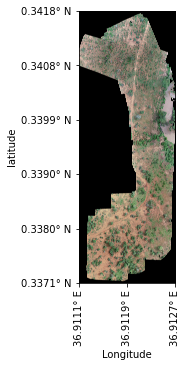

In [8]:
deg = u'\N{DEGREE SIGN}'

use_dms = False

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(pix4d_info['ortho'])

map_shape = pix4d_info['ortho'].shape

x_min = pix4d_info['x_origin']
y_min = pix4d_info['y_origin']
x_max = (x_min + (pix4d_info['pixel_width'] * (map_shape[1])))
y_max = (y_min + (pix4d_info['pixel_height'] * (map_shape[0])))

num_x_ticks = 3
ax.set_xticks(np.linspace(0, map_shape[1], num_x_ticks, dtype=int))
x_labels = np.linspace(x_min, np.abs(x_max), num_x_ticks, dtype=int)
_, lons = utm.to_latlon(x_labels, np.ones(num_x_ticks)*y_min, 37, 'N')
if use_dms:
    lons = [dd2dms(l) for l in lons]
    lons = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" E" for l in lons]
else:
    lons = [f"{l:2.4f}{deg} E" for l in lons]
_ = ax.set_xticklabels(lons, rotation="vertical")
ax.set_xlabel('Longitude')

num_y_ticks = 6
ax.set_yticks(np.linspace(0, map_shape[0], num_y_ticks, dtype=int))
y_labels = np.linspace(y_min, y_max, num_y_ticks, dtype=int)
lats, _ = utm.to_latlon(np.ones(num_y_ticks)*x_min, y_labels, 37, 'N')
if use_dms:
    lats = [dd2dms(l) for l in lats]
    lats = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" N" for l in lats]
else:
    lats = [f"{l:2.4f}{deg} N" for l in lats]
_ = ax.set_yticklabels(lats)
ax.set_ylabel('latitude')

In [9]:
r_dsm = cv2.rotate(dsm, cv2.ROTATE_90_COUNTERCLOCKWISE)
r_ortho = cv2.rotate(pix4d_info['ortho'], cv2.ROTATE_90_COUNTERCLOCKWISE)

In [22]:
scale = 1.0

s_dsm = cv2.resize(r_dsm, None, fx=scale, fy=scale)
s_ortho = cv2.resize(r_ortho, None, fx=scale, fy=scale)

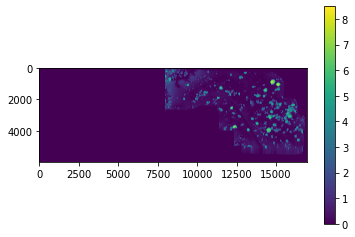

In [23]:
mask = np.where(s_ortho[...,0]==0, 0, 1)
mask[:, :int(8000*scale)] = 0
mask = mask.astype(np.uint8)
# Remove edge of map where elevation error high when choosing max height values
# for visualizations
kernel = np.ones((int(10*scale), int(10*scale)), np.uint8)
eroded_mask = cv2.erode(mask, kernel) 
masked_dsm = np.where(eroded_mask, s_dsm, 0)
height_max = masked_dsm.max() 
plt.imshow(masked_dsm)
plt.colorbar()

In [24]:
cmap = plt.cm.YlGn
cmap = plt.cm.Greens
cmap = plt.cm.viridis
rgb_dsm = create_rgb_dsm(s_dsm, cmap=cmap, dsm_mask=eroded_mask.astype(bool))

In [25]:
start_fade = int(6000 * scale)
end_fade = int(14000 * scale)
alphas = np.ones_like(s_dsm)
alphas[:, :start_fade] = 0
alphas[:, start_fade:end_fade] *= np.linspace(0, 1.0, (end_fade-start_fade))
alphas[:, end_fade:] = 1
alphas = np.log2(alphas+1)
alphas = np.expand_dims(alphas, axis=2)
alphas = np.repeat(alphas, 3, 2)
merge_landscape = (alphas * rgb_dsm + (1-alphas) * s_ortho).astype(np.uint8)
merge_landscape = np.where(s_ortho==0, s_ortho, merge_landscape)

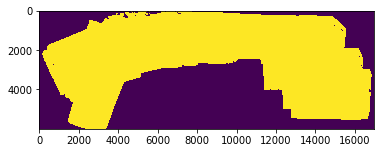

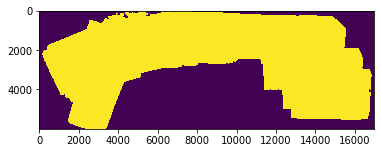

In [26]:
s_ortho = cv2.resize(r_ortho, None, fx=scale, fy=scale)
background_mask = np.where(s_ortho[...,0]==0, 0, 1)
background_mask = background_mask.astype(np.uint8)
plt.imshow(background_mask, interpolation='nearest')
contours, hierarchy = cv2.findContours(background_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
max_area = 0
max_ind = 0
for ind, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        max_ind = ind
cv2.drawContours(background_mask, contours, max_ind, 2, -1)
plt.figure()
plt.imshow(background_mask*100, interpolation='nearest')

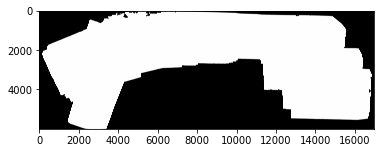

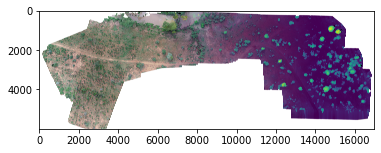

In [27]:

kernel = np.ones((int(100*scale), int(30*scale)), np.uint8)
# background_mask = cv2.dilate(background_mask, kernel) 

mask_3d = np.stack([background_mask, background_mask, background_mask], axis=2)
plt.imshow(mask_3d*255)

merge_landscape = np.where(mask_3d==0, 255, merge_landscape)
plt.figure()
plt.imshow(merge_landscape)

In [28]:
SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [19]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [20]:
def dd2dms(deg):
    # from https://en.proft.me/2015/09/20/converting-latitude-and-longitude-decimal-values-p/
    d = int(deg)
    md = (deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

In [21]:
lat, lon = utm.to_latlon(340000, 5710000, 37, 'N')
dd2dms(lat)

[51, 31, 6.3465815116154545]

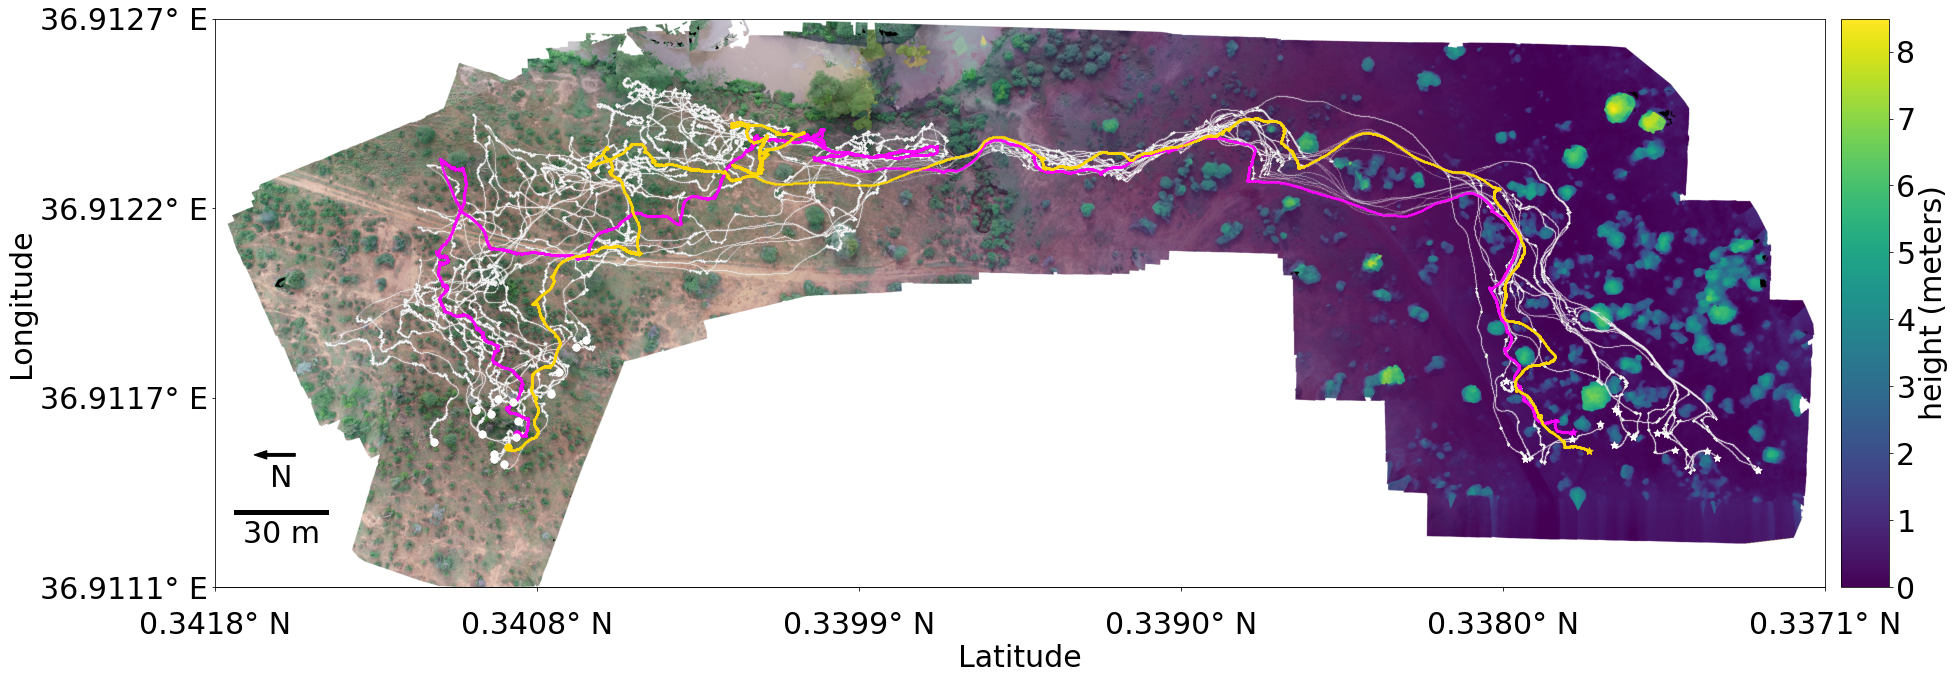

In [22]:
track_ind1 = 0
track_ind2 = 3

save_fig = False

color2 = 'gold'
color1 = 'magenta'

font_color = 'k'

use_dms = False # Use degree minute second ticks

# plt.style.use('dark_background')


fig, ax = plt.subplots(figsize=(30, 15))

merge_landscape

ax.imshow(merge_landscape)

# Trails
# ax.imshow(trail_probs, alpha=trail_alpha)

colors = ['w' for _ in utm_tracks]
colors[track_ind2] = color2
colors[track_ind1] = color1
alphas = [.1 for _ in utm_tracks]
alphas[track_ind1] = 1.0
alphas[track_ind2] = 1.0
thickness = [.2 for _ in utm_tracks]
thickness[track_ind1] =.4
thickness[track_ind2] = .4
for utm_track, color, alpha, s in zip(utm_tracks, colors, alphas, thickness):
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info)
    
    ax.scatter(raster_track[:, 1]*scale, 
                merge_landscape.shape[0]-(raster_track[:, 0]*scale), 
                s=s, c=color, alpha=alpha)
    ax.scatter(raster_track[:1, 1]*scale, 
                merge_landscape.shape[0]-(raster_track[:1, 0]*scale), 
                s=50, c=color, alpha=1.0)
    ax.scatter(raster_track[-1, 1]*scale, 
                merge_landscape.shape[0]-(raster_track[-1, 0]*scale), 
                s=50, c=color, alpha=1.0, marker="*")
    
alphas = [.0 for _ in utm_tracks]
alphas[track_ind1] = 1.0
alphas[track_ind2] = 1.0
for utm_track, color, alpha, s in zip(utm_tracks, colors, alphas, thickness):
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info)
    
    ax.scatter(raster_track[:, 1]*scale, 
                merge_landscape.shape[0]-(raster_track[:, 0]*scale), 
                s=s, c=color, alpha=alpha)
    ax.scatter(raster_track[:1, 1]*scale, 
                merge_landscape.shape[0]-(raster_track[:1, 0]*scale), 
                s=50, c=color, alpha=1.0)
    ax.scatter(raster_track[-1, 1]*scale, 
                merge_landscape.shape[0]-(raster_track[-1, 0]*scale), 
                s=50, c=color, alpha=1.0, marker="*")

# Add utm axis labels
show_axis = True
show_latlon = True
if show_axis:
    x_min = pix4d_info['x_origin']
    y_min = pix4d_info['y_origin']
    x_max = (x_min
                + (pix4d_info['pixel_width'] * (pix4d_info['elevation_r'].shape[1])))
    y_max = (y_min
                + (pix4d_info['pixel_height'] * (pix4d_info['elevation_r'].shape[0])))

    num_x_ticks = 6
    secax = ax.secondary_xaxis('bottom')
    secax.set_xticks(np.linspace(0, s_dsm.shape[1]-1, num_x_ticks, dtype=int))
    # Flipped, so on figure x is northing
    x_labels = np.linspace(y_min, y_max, num_x_ticks, dtype=int)
    if show_latlon:
        lats, _ = utm.to_latlon(np.ones(num_x_ticks)*x_min, x_labels, 37, 'N')
        if use_dms:
            lats = [dd2dms(l) for l in lats]
            lats = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" N" for l in lats]
        else:
            lats = [f"{l:2.4f}{deg} N" for l in lats]
        x_labels = lats
        secax.set_xlabel('Latitude')
    else:
        secax.set_xlabel('Meters')
    _ = secax.set_xticklabels(x_labels)
    ax.get_xaxis().set_visible(False)
    # secax.xaxis.tick_top()

    num_y_ticks = 4
    ax.set_yticks(np.linspace(0, s_dsm.shape[0]-1, num_y_ticks))
    # x_max and x_min order flipped because origin of ortho is bottomleft after
    # counter clockwise rotation
    y_labels = np.linspace(x_max, x_min, num_y_ticks, dtype=int)
    if show_latlon:
        _, lons = utm.to_latlon(y_labels, np.ones(num_y_ticks)*y_min, 37, 'N')
        if use_dms:
            lons = [dd2dms(l) for l in lons]
            lons = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" E" for l in lons]
        else:
            lons = [f"{l:2.4f}{deg} E" for l in lons]
        y_labels = lons
        ax.set_ylabel('Longitude')
    else:
        ax.set_ylabel('Meters')
    _ = ax.set_yticklabels(y_labels, rotation="horizontal")
    
    secax.tick_params(axis='x', which='major', pad=20)
else:
    ax.axis('off')
    
ax.set_aspect('equal')

# Add colorbar
ax_divider = make_axes_locatable(ax)
# add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="3%", pad="1%")
norm = mpl.colors.Normalize(vmin=0, vmax=height_max)

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb.set_label('height (meters)')

# Add scale bar
line_width = 5 * scale
text_size = 30 * scale
text_buffer = int(200 * scale)

bar_length_meters = 30
bar_length_pixels = bar_length_meters / pix4d_info['pixel_width'] * scale
bar_y_loc = 5200 * scale
bar_x_start = 200 * scale 
bar_x_end = bar_x_start + bar_length_pixels

ax.hlines(bar_y_loc, bar_x_start, bar_x_end, color=font_color, linewidth=line_width,
           antialiased=False)
text_x_loc = int((bar_x_start + bar_x_end) / 2)
text_y_loc = int(bar_y_loc + line_width + text_size + text_buffer)
# text_y_loc = bar_y_loc
txt = ax.text(text_x_loc, text_y_loc, f"{bar_length_meters} m", 
              size=text_size, ha="center", va='center', color=font_color)

# Add compass
arrow_length = int(300*scale)

ax.arrow(text_x_loc + (arrow_length/2), bar_y_loc - 600*scale, -arrow_length, 0, 
         width=30*scale, color=font_color)
txt = ax.text(text_x_loc, bar_y_loc - 350*scale, f"N", 
              size=text_size, ha="center", va='center', color=font_color)

file = os.path.join(local_paths['figure_folder'], 
                    "tracks_on_map_observation088_dsm_fade_latlon_alt_color.png")
if save_fig:
    fig.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight')

### Uncorected tracks

In [155]:
tracks_name = "tracks-complete.npy"
new_style = True

if new_style:
    tracks_file = os.path.join(local_paths['processed_folder'], observation_name, 
                               tracks_name)
else:   
    tracks_file = os.path.join(local_paths['processed_folder'], observation_name, 
                               "localizations", tracks_name)
tracks = np.load(tracks_file, allow_pickle=True)

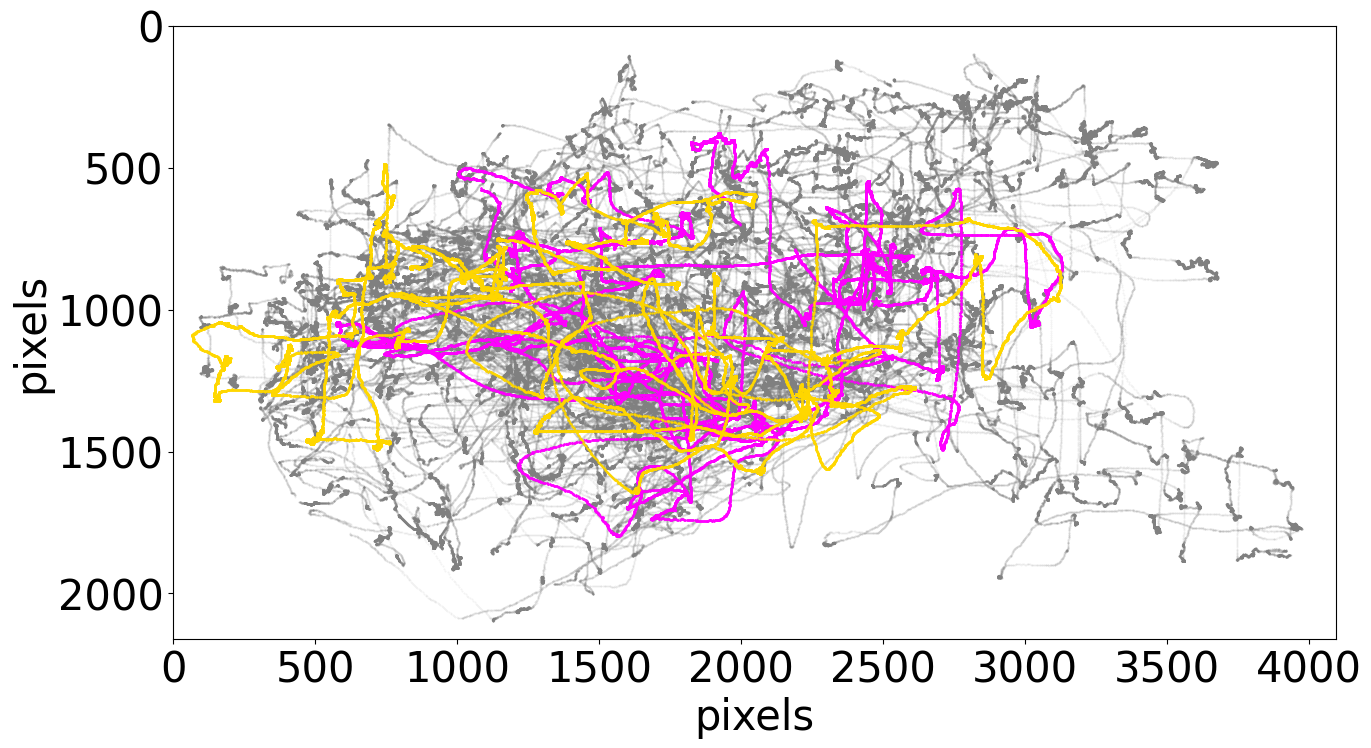

In [160]:
# plt.style.use('dark_background')

colors = ['gray' for _ in utm_tracks]
colors[track_ind2] = color2
colors[track_ind1] = color1
alphas = [0.1 for _ in utm_tracks]
alphas[track_ind1] = 1.0
alphas[track_ind2] = 1.0
thickness = [.2 for _ in utm_tracks]
thickness[track_ind1] =.4
thickness[track_ind2] = .4

plt.figure(figsize=(15, 15))
frame_shape = kmap.get_ungulates_frame_shape(supress_warning=True)
plt.imshow(np.ones((frame_shape[0], frame_shape[1], 3)))
for track, color, alpha, s in zip(tracks, colors, alphas, thickness):
    track = track['track']
    plt.scatter(track[:, 1], track[:, 0], c=color, alpha=alpha, s=s)
    plt.scatter(track[0, 1], track[0, 0], c=color, alpha=alpha, 
                 s=50)
    plt.scatter(track[-1, 1], track[-1, 0], c=color, alpha=alpha, 
                marker="*", s=50)
    
alphas = [0 for _ in utm_tracks]
alphas[track_ind1] = 1.0
alphas[track_ind2] = 1.0

# plt.figure(figsize=(20,20))
# plt.imshow(np.ones((frame_shape[0], frame_shape[1])))
for track, color, alpha, s in zip(tracks, colors, alphas, thickness):
    track = track['track']
    plt.scatter(track[:, 1], track[:, 0], c=color, alpha=alpha, s=s)
    plt.scatter(track[0, 1], track[0, 0], c=color, alpha=alpha, 
                 s=50)
    plt.scatter(track[-1, 1], track[-1, 0], c=color, alpha=alpha, 
                marker="*", s=50)
    
plt.gca().set_aspect('equal')
plt.xlabel('pixels')
plt.ylabel('pixels')

file = os.path.join(local_paths['figure_folder'], 
                    "tracks_in_frame_observation088_alt_color.png")
if save_fig:
    plt.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight',
               transparent=True)

### Game trail examples

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [16]:
trail_probs = np.load("./game-trails(demo)/observation088_trail_probs.npy")
trail_probs = cv2.rotate(trail_probs, cv2.ROTATE_90_COUNTERCLOCKWISE)

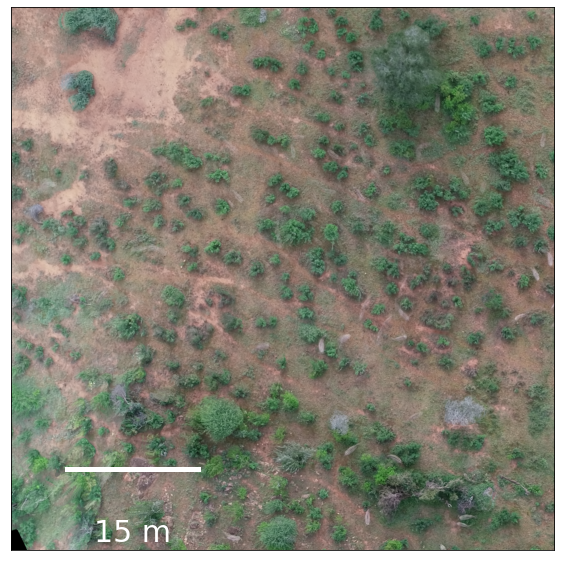

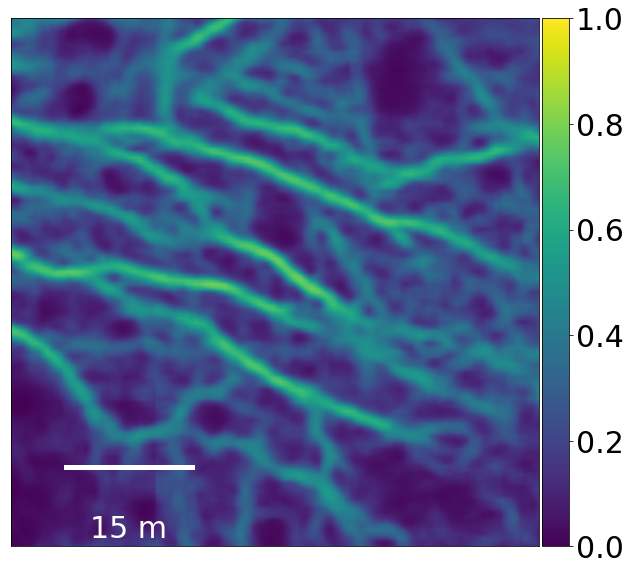

In [65]:
save_fig = True

square_size = 2000
min_x = 2500
min_y = 1500

font_color = 'w'

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(r_ortho[min_x:min_x+square_size, min_y:min_y+square_size])

# Add scale bar
line_width = 5 * scale
text_size = 30 * scale
text_buffer = int(200 * scale)

bar_length_meters = 15
bar_length_pixels = bar_length_meters / pix4d_info['pixel_width'] * scale
bar_y_loc = (square_size * .85) * scale
bar_x_start = 200 * scale 
bar_x_end = bar_x_start + bar_length_pixels

ax.hlines(bar_y_loc, bar_x_start, bar_x_end, color=font_color, linewidth=line_width,
           antialiased=False)
text_x_loc = int((bar_x_start + bar_x_end) / 2)
text_y_loc = int(bar_y_loc + line_width + text_size + text_buffer)
# text_y_loc = bar_y_loc
txt = ax.text(text_x_loc, text_y_loc, f"{bar_length_meters} m", 
              size=text_size, ha="center", va='center', color=font_color)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

file = os.path.join(local_paths['figure_folder'], 
                    "orthocrop_observation088.png")
if save_fig:
    fig.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight')


# Trails
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
trail = ax.imshow(trail_probs[min_x:min_x+square_size, min_y:min_y+square_size], vmin=0, vmax=1.0)

# Add scale bar
line_width = 5 * scale
text_size = 30 * scale
text_buffer = int(200 * scale)

bar_length_meters = 15
bar_length_pixels = bar_length_meters / pix4d_info['pixel_width'] * scale
bar_y_loc = (square_size * .85) * scale
bar_x_start = 200 * scale 
bar_x_end = bar_x_start + bar_length_pixels

ax.hlines(bar_y_loc, bar_x_start, bar_x_end, color=font_color, linewidth=line_width,
           antialiased=False)
text_x_loc = int((bar_x_start + bar_x_end) / 2)
text_y_loc = int(bar_y_loc + line_width + text_size + text_buffer)
# text_y_loc = bar_y_loc
txt = ax.text(text_x_loc, text_y_loc, f"{bar_length_meters} m", 
              size=text_size, ha="center", va='center', color=font_color)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
# cax = fig.add_axes([0.75, 0.15, 0.03, 0.7])

fig.colorbar(trail, cax=cax, orientation='vertical')

file = os.path.join(local_paths['figure_folder'], 
                    "gametrail_crop_observation088.png")
if save_fig:
    fig.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight')

In [38]:
# make the background white instead of black
r_ortho = np.where(mask_3d==0, 255, r_ortho)
trail_probs = np.where(background_mask==0, 0, trail_probs)

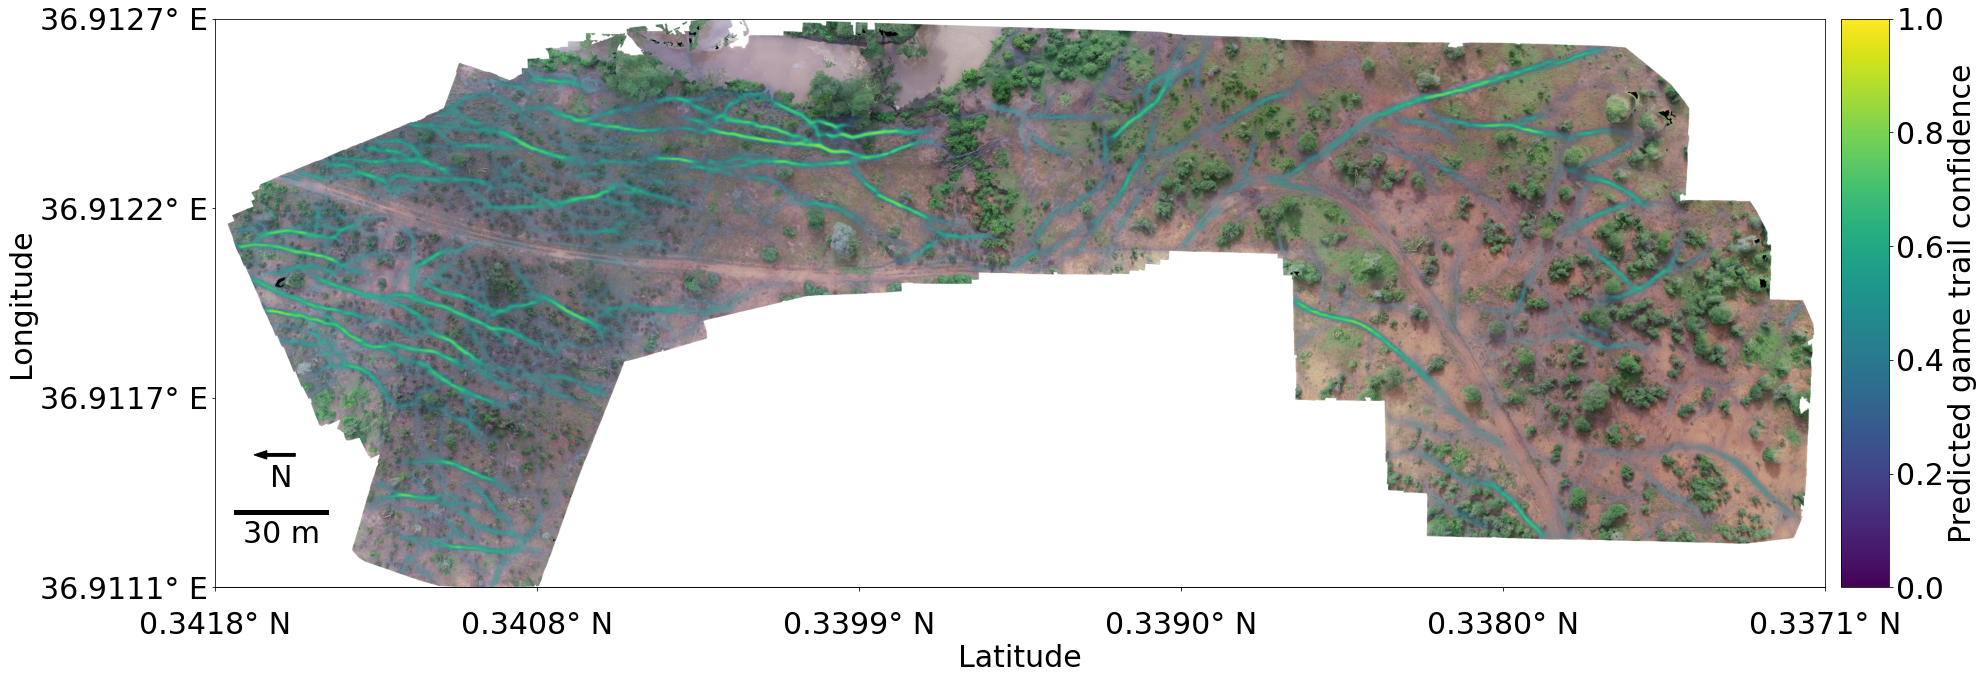

In [39]:
track_ind1 = 0
track_ind2 = 3

save_fig = True

color2 = 'gold'
color1 = 'magenta'

font_color = 'k'

use_dms = False # Use degree minute second ticks
draw_tracks = False

fig, ax = plt.subplots(figsize=(30, 15))

ax.imshow(r_ortho)

trail_alpha = trail_probs * 1.5
trail_alpha = np.where(trail_alpha > 1, 1, trail_alpha)
trail_prob_max = 1
ax.imshow(trail_probs, alpha=trail_alpha, vmin=0, 
          vmax=trail_prob_max)

# Trails
# ax.imshow(trail_probs, alpha=trail_alpha)

if draw_tracks:

    colors = ['w' for _ in utm_tracks]
    colors[track_ind2] = color2
    colors[track_ind1] = color1
    alphas = [.1 for _ in utm_tracks]
    alphas[track_ind1] = 1.0
    alphas[track_ind2] = 1.0
    thickness = [.2 for _ in utm_tracks]
    thickness[track_ind1] =.4
    thickness[track_ind2] = .4
    for utm_track, color, alpha, s in zip(utm_tracks, colors, alphas, thickness):
        raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info)

        ax.scatter(raster_track[:, 1]*scale, 
                    merge_landscape.shape[0]-(raster_track[:, 0]*scale), 
                    s=s, c=color, alpha=alpha)
        ax.scatter(raster_track[:1, 1]*scale, 
                    merge_landscape.shape[0]-(raster_track[:1, 0]*scale), 
                    s=50, c=color, alpha=1.0)
        ax.scatter(raster_track[-1, 1]*scale, 
                    merge_landscape.shape[0]-(raster_track[-1, 0]*scale), 
                    s=50, c=color, alpha=1.0, marker="*")

    alphas = [.0 for _ in utm_tracks]
    alphas[track_ind1] = 1.0
    alphas[track_ind2] = 1.0
    for utm_track, color, alpha, s in zip(utm_tracks, colors, alphas, thickness):
        raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info)

        ax.scatter(raster_track[:, 1]*scale, 
                    merge_landscape.shape[0]-(raster_track[:, 0]*scale), 
                    s=s, c=color, alpha=alpha)
        ax.scatter(raster_track[:1, 1]*scale, 
                    merge_landscape.shape[0]-(raster_track[:1, 0]*scale), 
                    s=50, c=color, alpha=1.0)
        ax.scatter(raster_track[-1, 1]*scale, 
                    merge_landscape.shape[0]-(raster_track[-1, 0]*scale), 
                    s=50, c=color, alpha=1.0, marker="*")

# Add utm axis labels
show_axis = True
show_latlon = True
if show_axis:
    x_min = pix4d_info['x_origin']
    y_min = pix4d_info['y_origin']
    x_max = (x_min
                + (pix4d_info['pixel_width'] * (pix4d_info['elevation_r'].shape[1])))
    y_max = (y_min
                + (pix4d_info['pixel_height'] * (pix4d_info['elevation_r'].shape[0])))

    num_x_ticks = 6
    secax = ax.secondary_xaxis('bottom')
    secax.set_xticks(np.linspace(0, s_dsm.shape[1]-1, num_x_ticks, dtype=int))
    # Flipped, so on figure x is northing
    x_labels = np.linspace(y_min, y_max, num_x_ticks, dtype=int)
    if show_latlon:
        lats, _ = utm.to_latlon(np.ones(num_x_ticks)*x_min, x_labels, 37, 'N')
        if use_dms:
            lats = [dd2dms(l) for l in lats]
            lats = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" N" for l in lats]
        else:
            lats = [f"{l:2.4f}{deg} N" for l in lats]
        x_labels = lats
        secax.set_xlabel('Latitude')
    else:
        secax.set_xlabel('Meters')
    _ = secax.set_xticklabels(x_labels)
    ax.get_xaxis().set_visible(False)
    # secax.xaxis.tick_top()

    num_y_ticks = 4
    ax.set_yticks(np.linspace(0, s_dsm.shape[0]-1, num_y_ticks))
    # x_max and x_min order flipped because origin of ortho is bottomleft after
    # counter clockwise rotation
    y_labels = np.linspace(x_max, x_min, num_y_ticks, dtype=int)
    if show_latlon:
        _, lons = utm.to_latlon(y_labels, np.ones(num_y_ticks)*y_min, 37, 'N')
        if use_dms:
            lons = [dd2dms(l) for l in lons]
            lons = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" E" for l in lons]
        else:
            lons = [f"{l:2.4f}{deg} E" for l in lons]
        y_labels = lons
        ax.set_ylabel('Longitude')
    else:
        ax.set_ylabel('Meters')
    _ = ax.set_yticklabels(y_labels, rotation="horizontal")
    
    secax.tick_params(axis='x', which='major', pad=20)
else:
    ax.axis('off')
    
ax.set_aspect('equal')

# Add colorbar
ax_divider = make_axes_locatable(ax)
# add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="3%", pad="1%")
norm = mpl.colors.Normalize(vmin=0, vmax=trail_prob_max)

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb.set_label('Predicted game trail confidence')

# Add scale bar
line_width = 5 * scale
text_size = 30 * scale
text_buffer = int(200 * scale)

bar_length_meters = 30
bar_length_pixels = bar_length_meters / pix4d_info['pixel_width'] * scale
bar_y_loc = 5200 * scale
bar_x_start = 200 * scale 
bar_x_end = bar_x_start + bar_length_pixels

ax.hlines(bar_y_loc, bar_x_start, bar_x_end, color=font_color, linewidth=line_width,
           antialiased=False)
text_x_loc = int((bar_x_start + bar_x_end) / 2)
text_y_loc = int(bar_y_loc + line_width + text_size + text_buffer)
# text_y_loc = bar_y_loc
txt = ax.text(text_x_loc, text_y_loc, f"{bar_length_meters} m", 
              size=text_size, ha="center", va='center', color=font_color)

# Add compass
arrow_length = int(300*scale)

ax.arrow(text_x_loc + (arrow_length/2), bar_y_loc - 600*scale, -arrow_length, 0, 
         width=30*scale, color=font_color)
txt = ax.text(text_x_loc, bar_y_loc - 350*scale, f"N", 
              size=text_size, ha="center", va='center', color=font_color)

file = os.path.join(local_paths['figure_folder'], 
                    "gametails_on_map_observation088_latlon_alt_color.png")
if save_fig:
    fig.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight')